<>:179: SyntaxWarning: invalid escape sequence '\s'
<>:189: SyntaxWarning: invalid escape sequence '\s'
<>:179: SyntaxWarning: invalid escape sequence '\s'
<>:189: SyntaxWarning: invalid escape sequence '\s'
C:\Users\soura\AppData\Local\Temp\ipykernel_17848\2780393001.py:179: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$)')
C:\Users\soura\AppData\Local\Temp\ipykernel_17848\2780393001.py:189: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$) Chebyshev Davidson')
C:\Users\soura\miniconda3\envs\smu_research\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(


Mat-Mat 304
Vec-Vec 2
Mat-Vec 2435


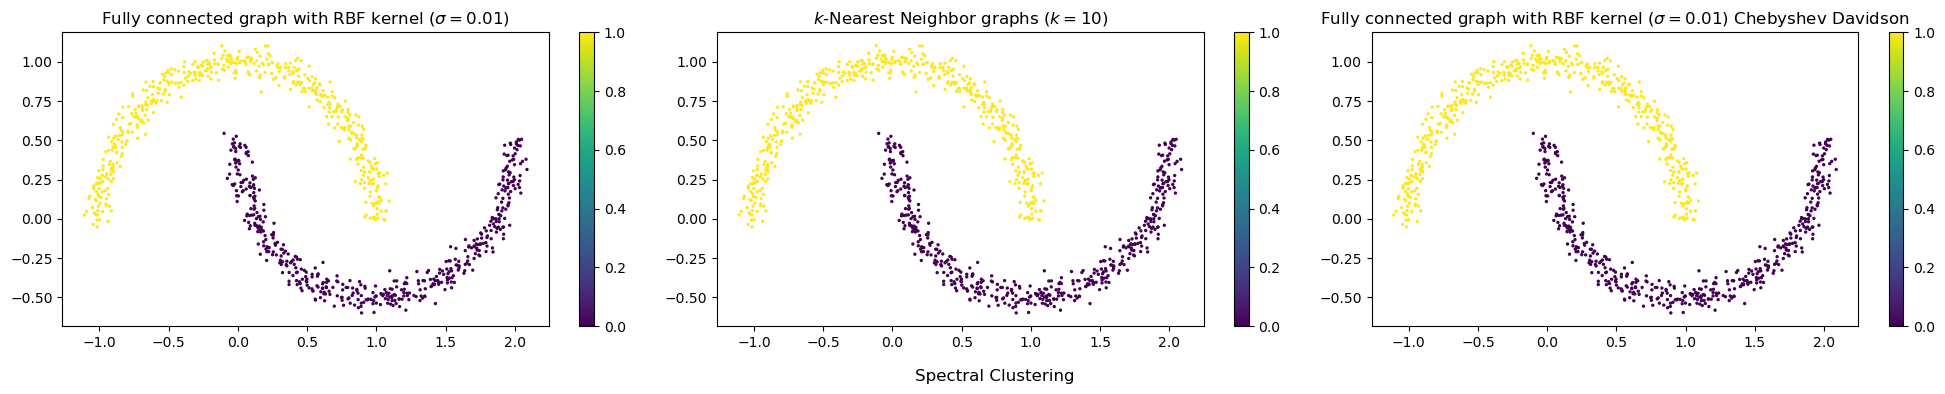

In [1]:
# # Adapted from  https://github.com/zhangyk8/Spectral-Clustering/blob/master/spectral_clustering.py
########################################

from sklearn import datasets
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
import gzip


import chebDev

def writeMatrix(mat, filename):
    with open(filename,'wt') as f:
        for i in range(mat.shape[0]):
            f.write(','.join([str(a) for a in mat[i,:]])+'\n')

    
def checkHermitian(mat, name):
    for i in range(mat.shape[0]):
        for j in range(i, mat.shape[1]):
            if mat[i, j] != mat[j, i] and (abs(mat[i,j])>1e-14 and abs(mat[j,i])>1e-14):
                print(name,'not hermitian', i,j, mat[i,j], mat[j,i])
                raise ValueError("Matrix Not Hermitian")

def maskFloatErr(mat, tol = 1e-14):
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if abs(mat[i,j]) < 1e-14:
                mat[i,j]=0
    return mat

def makeHermitianIfBelowFloatErr(mat, tol = 1e-14):
    for i in range(mat.shape[0]):
        for j in range(i, mat.shape[1]):
            if mat[i, j] != mat[j, i]:
                if abs(mat[i,j]) < 1e-14 and abs(mat[j,i]) < 1e-14:
                    mat[i,j]=0
                    mat[j,i]=0
                else:
                    print('not hermitian', i,j, mat[i,j], mat[j,i])
                    raise ValueError("Matrix Not Hermitian")
    return mat


def getEig(mat, eig_algo, k=None):
    if eig_algo == 'np_linalg':
        return np.linalg.eig(mat)
    elif eig_algo == 'cheb_dav':
        #mat = makeHermitianIfBelowFloatErr(mat)
        #checkHermitian(mat,'cheb_dav')
        val, vec, matmat, vecvec, matvec = chebDev.cheb_dav(mat,k)
        print('Mat-Mat',matmat)
        print('Vec-Vec',vecvec)
        print('Mat-Vec',matvec)
        return val, np.asarray(vec)
    else:
        raise Exception ("Invalid Eigen-Algorithm choice. Must be 'np_linalg' or 'cheb_dav'")

# Based on "A Tutorial on Spectral Clustering" written by Ulrike von Luxburg
def Spectral_Clustering(X, K=8, adj=True, metric='euclidean', sim_graph='fully_connect', sigma=1, knn=10, epsi=0.5, normalized=1, eig_algo='np_linalg'):
    '''
    Input: 
        X : [n_samples, n_samples] numpy array if adj=True, or, a [n_samples_a, n_features] array otherwise;
        K: int, The number of clusters;
        adj: boolean, Indicating whether the adjacency matrix is pre-computed. Default: True;
        metric: string, A parameter passing to "scipy.spatial.distance.pdist()" function for computing the adjacency matrix (deprecated if adj=True). Default: 'euclidean';
        sim_graph: string, Specifying the type of similarity graphs. Choices are ['fully_connect', 'eps_neighbor', 'knn', 'mutual_knn']. Default: 'fully_connect';
        sigma: float, The variance for the Gaussian (aka RBF) kernel (Used when sim_graph='fully_connect'). Default: 1;
        knn: int, The number of neighbors used to construct k-Nearest Neighbor graphs (Used when sim_graph='knn' or 'mutual_knn'). Default: 10;
        epsi: float, A parameter controlling the connections between points (Used when sim_graph='eps_neighbor'). Default: 0.5;
        normalized: int, 1: Random Walk normalized version; 2: Graph cut normalized version; other integer values: Unnormalized version. Default: 1.
    Output:
        sklearn.cluster class, Attributes:
            cluster_centers_ : array, [n_clusters, n_features], Coordinates of cluster centers in K-means;
            labels_ : Labels of each point;
            inertia_ : float, Sum of squared distances of samples to their closest cluster center in K-means;
            n_iter_ : int, Number of iterations run in K-means.
    '''
    # Compute the adjacency matrix
    if not adj:
        Adj_mat = squareform(pdist(X, metric=metric))
    else:
        Adj_mat = X
    # Compute the weighted adjacency matrix based on the type of similarity graphs
    if sim_graph ==  'fully_connect':
        W = np.exp(-Adj_mat/(2*sigma))
    elif sim_graph == 'eps_neighbor':
        W = (Adj_mat <= epsi).astype('float64')
    elif sim_graph == 'knn':
        W = np.zeros(Adj_mat.shape)
        # Sort the adjacency matrx by rows and record the indices
        Adj_sort = np.argsort(Adj_mat, axis=1)
        # Set the weight (i,j) to 1 when either i or j is within the k-nearest neighbors of each other
        for i in range(Adj_sort.shape[0]):
            W[i,Adj_sort[i,:][:(knn+1)]] = 1
    elif sim_graph == 'mutual_knn':
        W1 = np.zeros(Adj_mat.shape)
        # Sort the adjacency matrx by rows and record the indices
        Adj_sort = np.argsort(Adj_mat, axis=1)
        # Set the weight W1[i,j] to 0.5 when either i or j is within the k-nearest neighbors of each other (Flag)
        # Set the weight W1[i,j] to 1 when both i and j are within the k-nearest neighbors of each other
        for i in range(Adj_mat.shape[0]):
            for j in Adj_sort[i,:][:(knn+1)]:
                if i == j:
                    W1[i,i] = 1
                elif W1[i,j] == 0 and W1[j,i] == 0:
                    W1[i,j] = 0.5
                else:
                    W1[i,j] = W1[j,i] = 1
        W = np.copy((W1 > 0.5).astype('float64'))
    elif sim_graph == 'raw': #Use adjacency matrix as affinity matrix
        W = Adj_mat
    else:
        raise ValueError("The 'sim_graph' argument should be one of the strings, 'fully_connect', 'eps_neighbor', 'knn', or 'mutual_knn'!")
        
    # Compute the degree matrix and the unnormalized graph Laplacian
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    checkHermitian(W,'W')
    checkHermitian(D,'D')
    checkHermitian(L,'L')
    # Compute the matrix with the first K eigenvectors as columns based on the normalized type of L
    if normalized == 1:   ## Random Walk normalized version
        # Compute the inverse of the diagonal matrix
        D_inv = np.diag(1/np.diag(D))
        # Compute the eigenpairs of L_{rw}
        mat = np.dot(D_inv, L)
        #checkHermitian(mat,'L_rw')
        #mat = makeHermitianIfBelowFloatErr(mat)
        writeMatrix(W, 'W.mat')
        #checkHermitian(mat,'L_rw')

        Lambdas, V = getEig(mat, eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
    elif normalized == 2:   ## Graph cut normalized version
        # Compute the square root of the inverse of the diagonal matrix
        D_inv_sqrt = np.diag(1/np.sqrt(np.diag(D)))
        # Compute the eigenpairs of L_{sym}
        Lambdas, V = getEig(np.matmul(np.matmul(D_inv_sqrt, L), D_inv_sqrt), eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
        if any(V_K.sum(axis=1) == 0):
            raise ValueError("Can't normalize the matrix with the first K eigenvectors as columns! Perhaps the number of clusters K or the number of neighbors in k-NN is too small.")
        # Normalize the row sums to have norm 1
        V_K = V_K/np.reshape(np.linalg.norm(V_K, axis=1), (V_K.shape[0], 1))
    else:   ## Unnormalized version
        # Compute the eigenpairs of L
        Lambdas, V = getEig(L, eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
        
    # Conduct K-Means on the matrix with the first K eigenvectors as columns
    kmeans = KMeans(n_clusters=K, init='k-means++', random_state=0).fit(V_K)
    return kmeans


def main():
    # Generate a toy dataset...
    moon_data, moon_labels = datasets.make_moons(1000, noise=0.05)
    # Compute the adjacency matrix
    Adj_mat = squareform(pdist(moon_data, metric='euclidean'))
    # Spectral clustering...
    spec_re1 = Spectral_Clustering(Adj_mat, K=2, sim_graph='fully_connect', sigma=0.01, normalized=0)
    spec_re2 = Spectral_Clustering(Adj_mat, K=2, sim_graph='knn', knn=10, normalized=1)
    spec_re3 = Spectral_Clustering(Adj_mat, K=2, sim_graph='fully_connect', sigma=0.01, normalized=2, eig_algo='cheb_dav')

    # Often need to change figsize when doing subplots
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re1.labels_, s=2)
    plt.colorbar()
    plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$)')

    plt.subplot(1, 3, 2)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re2.labels_, s=2)
    plt.colorbar()
    plt.title('$k$-Nearest Neighbor graphs ($k=10$)')

    plt.subplot(1, 3, 3)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re3.labels_, s=2)
    plt.colorbar()
    plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$) Chebyshev Davidson')

    plt.suptitle('Spectral Clustering', y=-0.01)

    # Automatrically adjust padding between subpots 
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()    

In [2]:

def cut(adj_matrix, cluster, rest_of_graph):
    """
    Compute the cut between a cluster and the rest of the graph.
    """
    cut_value = 0
    for i in cluster:
        for j in rest_of_graph:
            cut_value += adj_matrix[i][j]
    return cut_value/2

def volume(adj_matrix, cluster):
    """
    Compute the volume of a cluster.
    """
    vol_value = 0
    for i in cluster:
        vol_value += np.sum(adj_matrix[i])
    return vol_value

def ratio_cut(adj_matrix, clusters):
    """
    Compute the RatioCut of a graph partitioning.
    
    Parameters:
    adj_matrix : numpy.ndarray
        Adjacency matrix of the graph (nxn).
    clusters : list of lists
        List containing k clusters, each cluster is a list of node indices.
        
    Returns:
    float
        The RatioCut value.
    """
    ratio_cut_value = 0
    n = adj_matrix.shape[0]
    
    for cluster in clusters:
        rest_of_graph = list(set(range(n)) - set(cluster))
        cut_value = cut(adj_matrix, cluster, rest_of_graph)
        ratio_cut_value += cut_value / len(cluster)
    
    return ratio_cut_value


def ncut(adj_matrix, clusters):
    """
    Compute the Normalized Cut (NCut) of a graph partitioning.
    
    Parameters:
    adj_matrix : numpy.ndarray
        Adjacency matrix of the graph (nxn).
    clusters : list of lists
        List containing k clusters, each cluster is a list of node indices.
        
    Returns:
    float
        The NCut value.
    """


    ncut_value = 0
    n = adj_matrix.shape[0]

    for cluster in clusters:
        rest_of_graph = list(set(range(n)) - set(cluster))
        cut_value = cut(adj_matrix, cluster, rest_of_graph)
        vol_value = volume(adj_matrix, cluster)
        ncut_value += cut_value / vol_value
    
    return ncut_value


from collections import Counter
def variation_of_information(X_labels, Y_labels):
    x_keys = set(X_labels)
    y_keys = set(Y_labels)
    
    X = {x:[] for x in x_keys}
    Y = {y:[] for y in y_keys}
    for i,x in enumerate(X_labels):
        X[x].append(i)
    for j,y in enumerate(Y_labels):
        Y[y].append(j)

    n = float(sum([len(x) for i,x in X.items()]))
    sigma = 0.0
    for i,x in X.items():
        p = len(x) / n
        for j,y in Y.items():
            q = len(y) / n
            r = len(set(x) & set(y)) / n
            if r > 0.0:
                sigma += r * (np.log2(r / p) + np.log2(r / q))
    
    return abs(sigma)



In [2]:
from sklearn.metrics import f1_score
from sklearn.metrics import normalized_mutual_info_score



Mat-Mat 294
Vec-Vec 2
Mat-Vec 2355
Mat-Mat 384
Vec-Vec 2
Mat-Vec 3075


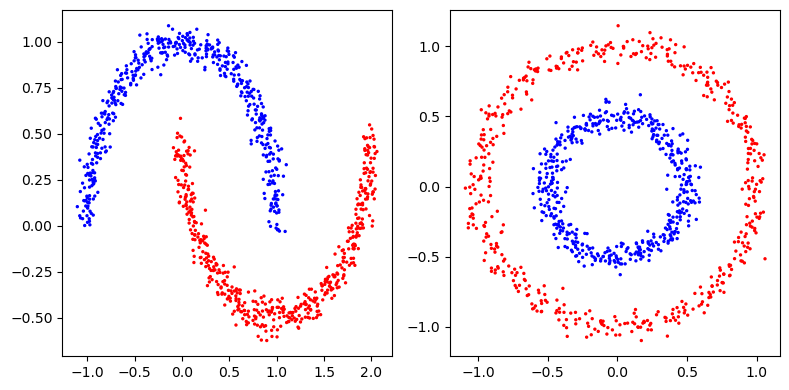

In [3]:
    moon_data, moon_labels = datasets.make_moons(1000, noise=0.05)
    circles_data, circles_labels = datasets.make_circles(n_samples=1000, noise=0.05, factor=0.5)

    # Compute the adjacency matrix
    Adj_mat1 = squareform(pdist(moon_data, metric='euclidean'))
    Adj_mat2 = squareform(pdist(circles_data, metric='euclidean'))

    # Spectral clustering...
    spec_re1 = Spectral_Clustering(Adj_mat1, K=2, sim_graph='fully_connect', sigma=0.01, normalized=2, eig_algo='cheb_dav')
    spec_re2 = Spectral_Clustering(Adj_mat2, K=2, sim_graph='fully_connect', sigma=0.01, normalized=2, eig_algo='cheb_dav')

    # Often need to change figsize when doing subplots
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re1.labels_, s=2, cmap='bwr')


    plt.subplot(1, 2, 2)
    plt.scatter(x=circles_data[:, 0], y=circles_data[:, 1], c=spec_re2.labels_, s=2, cmap='bwr')


    # Automatrically adjust padding between subplots 
    plt.tight_layout()
    #plt.savefig("../../Reports/tex/toyexmples.png")
    plt.show()


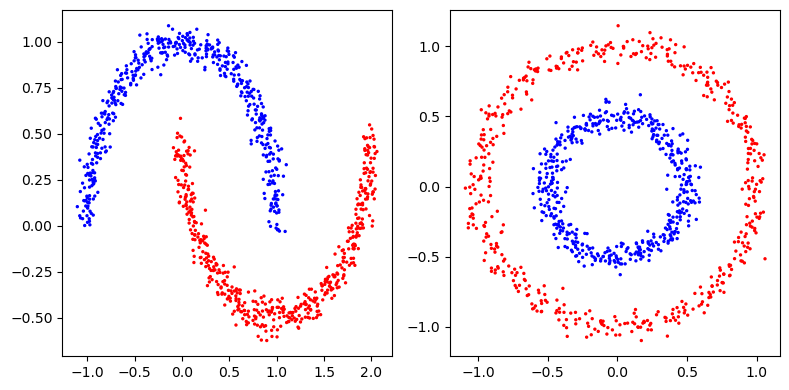

Moons:
	F1 Score: 1.0
	NMI: 1.0


NameError: name 'variation_of_information' is not defined

In [4]:
sk_moons = Spectral_Clustering(Adj_mat1, K=2, sim_graph='fully_connect', sigma=0.01, normalized=2)
sk_circles = Spectral_Clustering(Adj_mat2, K=2, sim_graph='fully_connect', sigma=0.01, normalized=2)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=sk_moons.labels_, s=2, cmap='bwr')


plt.subplot(1, 2, 2)
plt.scatter(x=circles_data[:, 0], y=circles_data[:, 1], c=sk_circles.labels_, s=2, cmap='bwr')


# Automatrically adjust padding between subplots 
plt.tight_layout()
#plt.savefig("../../Reports/tex/toyexmples.png")
plt.show()

print('Moons:\n\tF1 Score:', f1_score(sk_moons.labels_, spec_re1.labels_))
print('\tNMI:',normalized_mutual_info_score(sk_moons.labels_, spec_re1.labels_))
print('\tVI:',variation_of_information(sk_moons.labels_, spec_re1.labels_))

print('Circles:\n\tF1 Score:',f1_score(sk_circles.labels_, spec_re2.labels_))
print('\tNMI:',normalized_mutual_info_score(sk_circles.labels_, spec_re2.labels_))
print('\tVI:',variation_of_information(sk_circles.labels_, spec_re2.labels_))


In [5]:
X_labels = sk_moons.labels_
Y_labels = spec_re2.labels_

x_keys = set(X_labels)
y_keys = set(Y_labels)

X = {x:[] for x in x_keys}
Y = {y:[] for y in y_keys}
for i,x in enumerate(X_labels):
    X[x].append(i)
for j,y in enumerate(Y_labels):
    Y[y].append(j)

n = float(sum([len(x) for i,x in X.items()]))
sigma = 0.0
for i,x in X.items():
    p = len(x) / n
    for j,y in Y.items():
        q = len(y) / n
        r = len(set(x) & set(y)) / n
        if r > 0.0:
            sigma += r * (np.log2(r / p) + np.log2(r / q))
abs(sigma)


np.float64(1.997206040475619)

In [1]:
from networkx.generators.community import LFR_benchmark_graph
import networkx as nx
import umap

n = 2500
tau1 = 3
tau2 = 1.8
mu = 0.03
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=5, min_community=100, seed=10
)
print(G)

C:\Users\soura\miniconda3\envs\smu_research\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Graph with 2500 nodes and 5409 edges


In [14]:
mat = nx.adjacency_matrix(G).todense()
for i in range(mat.shape[0]):
    mat[i][i]=0

In [15]:
k=15
print('K=',k)
spec_re1 = Spectral_Clustering(mat, K=k, sim_graph='fully_connect', sigma=0.01, normalized=2)
clusters = []
for c in set(spec_re1.labels_):
    cluster = [i for i,a in enumerate(spec_re1.labels_) if a==c]
    clusters.append(cluster)


print("Ratio Cut:",ratio_cut(mat, clusters))

print("N Cut:",ncut(mat, clusters))


K= 15
Ratio Cut: 26.102440171274292
N Cut: 5.55197111135766


C:\Users\soura\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


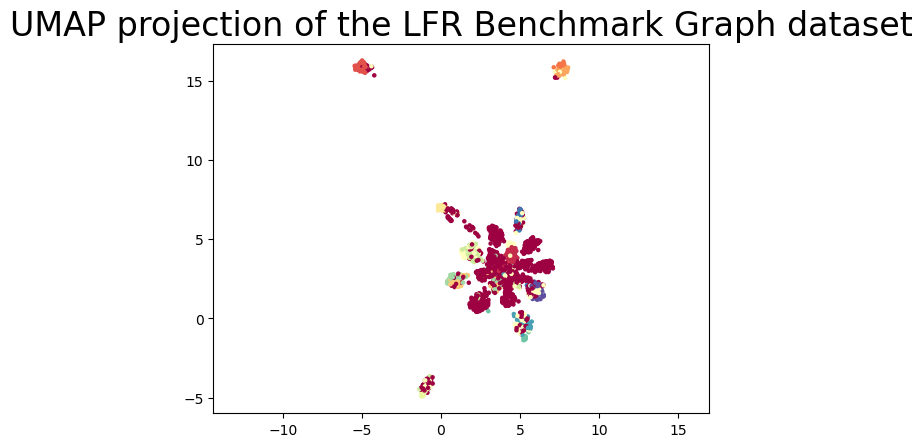

In [16]:
reducer = umap.UMAP(random_state=42)
reducer.fit(mat)
embedding = reducer.transform(mat)
plt.scatter(embedding[:, 0], embedding[:, 1], c=spec_re1.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the LFR Benchmark Graph dataset', fontsize=24);


Mat-Mat 26
Vec-Vec 2
Mat-Vec 209
Time taken 0.2695174217224121


C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


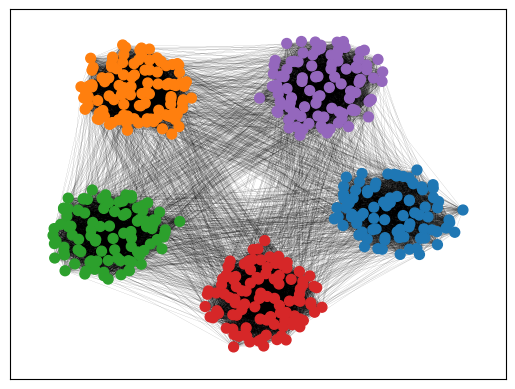

In [40]:
import time
G_gaussian = nx.gaussian_random_partition_graph(n=500, s=100, v=10, p_in=0.98, p_out=0.02, seed=31)
mat = nx.adjacency_matrix(G_gaussian).todense()
for i in range(mat.shape[0]):
    mat[i][i]=0
starttime = time.time()
spec_gaussian = Spectral_Clustering(mat, K=5, metric='euclidean', sim_graph='raw', eig_algo='cheb_dav', normalized=2)
print('Time taken',(time.time()-starttime))
colorDict = plt.get_cmap('tab10')
nx.draw_networkx(G_gaussian, node_size=50, width=0.05, with_labels=False, node_color=[colorDict.colors[c] for c in spec_gaussian.labels_])
#plt.savefig('../../Reports/tex/networkx_gaussian_clustering.png')
plt.show()

C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Time taken 0.36600518226623535


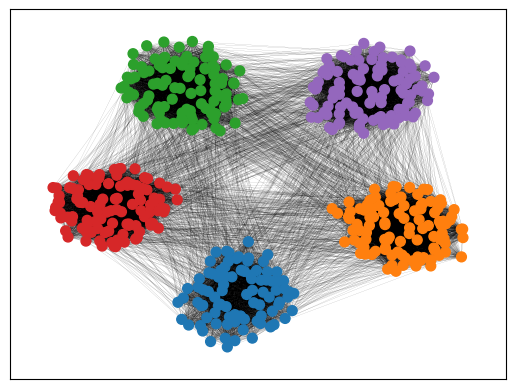

F-Score: 1.0
NMI: 1.0
VI: 0.0


In [41]:
starttime = time.time()
spec_lin_gaussian = Spectral_Clustering(mat, K=5, metric='euclidean', sim_graph='raw', normalized=2)
print('Time taken',(time.time()-starttime))

colorDict = plt.get_cmap('tab10')
nx.draw_networkx(G_gaussian, node_size=50, width=0.05, with_labels=False, node_color=[colorDict.colors[c] for c in spec_lin_gaussian.labels_])
#plt.savefig('../../Reports/tex/networkx_gaussian_clustering.png')
plt.show()
print('F-Score:',f1_score(spec_gaussian.labels_, spec_lin_gaussian.labels_, average='micro'))
print('NMI:',normalized_mutual_info_score(spec_gaussian.labels_, spec_lin_gaussian.labels_))
print('VI:',variation_of_information(spec_gaussian.labels_, spec_lin_gaussian.labels_))


Mat-Mat 46
Vec-Vec 2
Mat-Vec 369
Time taken 0.2679750919342041


C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


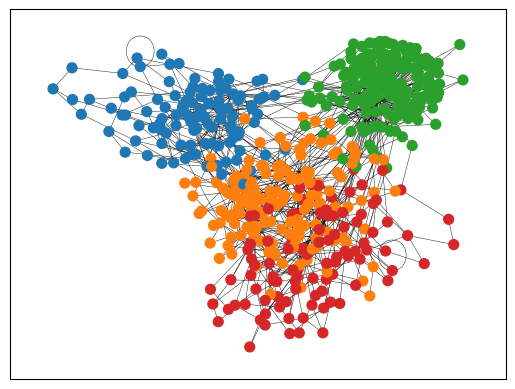

In [48]:

n = 500
tau1 = 3
tau2 = 1.5
mu = 0.1
G_LFR = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=5, min_community=60, seed=10
)

mat = nx.adjacency_matrix(G_LFR).todense()
for i in range(mat.shape[0]):
    mat[i][i]=0


starttime = time.time()
spec_lfr = Spectral_Clustering(mat, K=4, metric='euclidean', sim_graph='raw', eig_algo='cheb_dav', normalized=2)
print('Time taken',(time.time()-starttime))

colorDict = plt.get_cmap('tab10')
nx.draw_networkx(G_LFR, node_size=50, width=0.3, with_labels=False, node_color=[colorDict.colors[c] for c in spec_lfr.labels_])
#plt.savefig('../../Reports/tex/networkx_LFR_benchmark.png')
plt.show()

C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Time taken 0.3821425437927246


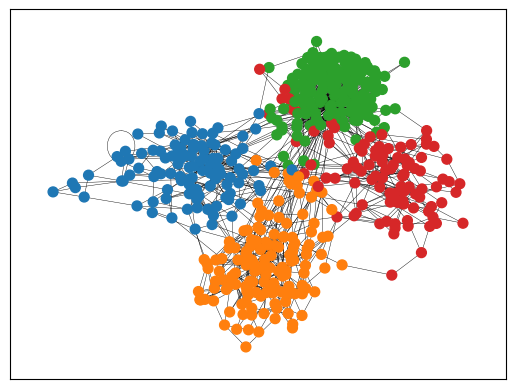

F-Score: 1.0
NMI: 1.0
VI: 0.0


In [49]:
starttime = time.time()
spec_lin_lfr = Spectral_Clustering(mat, K=4, metric='euclidean', sim_graph='raw', normalized=2)
print('Time taken',(time.time()-starttime))

colorDict = plt.get_cmap('tab10')
nx.draw_networkx(G_LFR, node_size=50, width=0.3, with_labels=False, node_color=[colorDict.colors[c] for c in spec_lfr.labels_])
#plt.savefig('../../Reports/tex/networkx_LFR_benchmark.png')
plt.show()
print('F-Score:',f1_score(spec_lfr.labels_, spec_lin_lfr.labels_, average='micro'))
print('NMI:',normalized_mutual_info_score(spec_lfr.labels_, spec_lin_lfr.labels_))
print('VI:',variation_of_information(spec_lfr.labels_, spec_lin_lfr.labels_))


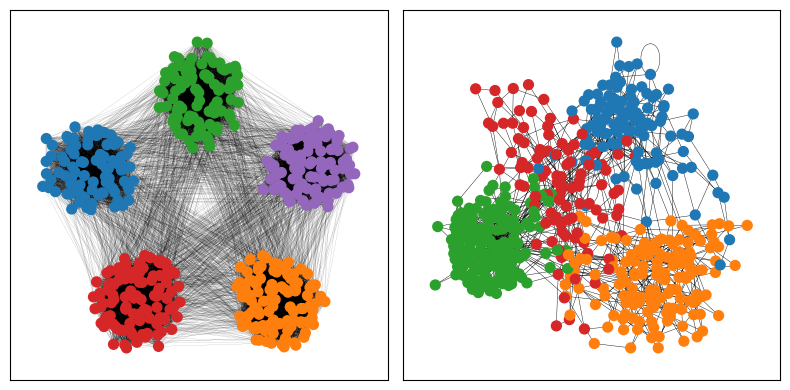

In [19]:
fig,axs = plt.subplots(1,2, figsize=(8, 4))
nx.draw_networkx(G_gaussian, node_size=50, width=0.05, with_labels=False, node_color=[colorDict.colors[c] for c in spec_gaussian.labels_], ax=axs[0])
nx.draw_networkx(G_LFR, node_size=50, width=0.3, with_labels=False, node_color=[colorDict.colors[c] for c in spec_lfr.labels_], ax=axs[1])

# Automatrically adjust padding between subplots 
plt.tight_layout()
#plt.savefig("../../Reports/tex/networkx.png")
plt.show()



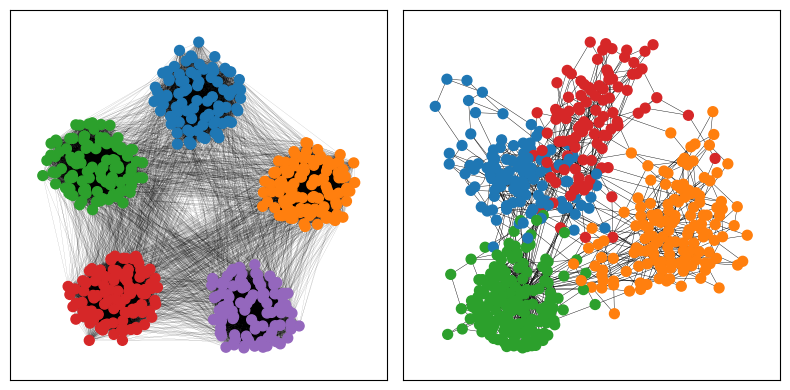

In [20]:
fig,axs = plt.subplots(1,2, figsize=(8, 4))
nx.draw_networkx(G_gaussian, node_size=50, width=0.05, with_labels=False, node_color=[colorDict.colors[c] for c in spec_gaussian.labels_], ax=axs[0])
nx.draw_networkx(G_LFR, node_size=50, width=0.3, with_labels=False, node_color=[colorDict.colors[c] for c in spec_lfr.labels_], ax=axs[1])

# Automatrically adjust padding between subplots 
plt.tight_layout()
#plt.savefig("../../Reports/tex/networkx.png")
plt.show()



In [11]:
import tarfile
import numpy as np 
import pandas as pd
from io import StringIO

tar = tarfile.open('C:/Users/soura/Downloads/__ppi_networks.1.0.2.tar.gz', 'r:gz')
for member in tar.getmembers():
     f = tar.extractfile(member)
     if f:
         content = f.read()
         Data = pd.read_csv(StringIO(content.decode('ascii')), delimiter='\t')
tar.close()
display(Data)

,INTERACTOR_A,INTERACTOR_B
0,sc20,sc2175
1,sc20,sc1070
2,sc20,sc1418
3,sc20,sc1560
4,sc20,sc700
...,...,...
164713,sc4037,sc4658
164714,sc4037,sc3475
164715,sc4037,sc4115
164716,sc4037,sc3703


In [14]:
astroPhDf = pd.read_csv('../../DataSets/SNAP/ca-AstroPh.txt.gz', compression='gzip', comment='#', delimiter='\t', names=['From','To'])
uniqueAuth = set(astroPhDf.From.to_list()+astroPhDf.To.to_list())
auth_id_map = {a:i for i,a in enumerate(sorted(uniqueAuth))}
len(auth_id_map)

18772

In [15]:
adjMat = np.zeros((len(auth_id_map), len(auth_id_map)))
for idx,row in astroPhDf.iterrows():
    from_id = auth_id_map[row['From']]
    to_id = auth_id_map[row['To']]
    adjMat[from_id][to_id] = 1
    adjMat[to_id][from_id] = 1

adjMat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
spec_astroPhy = Spectral_Clustering(adjMat, K=2, metric='euclidean', sim_graph='raw', normalized=2)

In [ ]:
from collections import Counter
Counter(spec_astroPhy.labels_)

In [17]:
import sklearn

sksc = sklearn.cluster.SpectralClustering(n_clusters=14, affinity='precomputed').fit(adjMat)
sksc.labels_

C:\Users\soura\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0])

In [37]:
!python --version

Python 3.12.3


In [ ]:
Counter(sksc.labels_)

In [23]:
!pip install pynndescent==0.5.13

   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ------- -------------------------------- 10.2/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB 1.0 MB/s eta 0:00:00
  Attempting uninstall: pynndescent
    Found existing installation: pynndescent 0.5.10
    Uninstalling pynndescent-0.5.10:
      Successfully uninstalled pynndescent-0.5.10


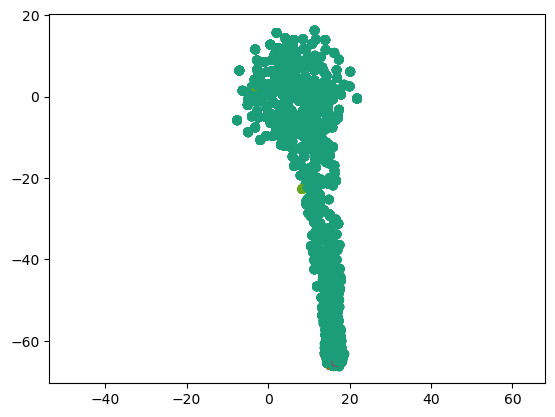

In [18]:
import umap
reducer = umap.UMAP()
#embedding = reducer.fit_transform(adjMat)
reducer.fit(adjMat)
embedding = reducer.transform(adjMat)

#plt.scatter(embedding[:, 0], embedding[:, 1], c=spec_astroPhy.labels_, cmap='Dark2')
plt.scatter(embedding[:, 0], embedding[:, 1], c=sksc.labels_, cmap='Dark2')
plt.gca().set_aspect('equal', 'datalim')



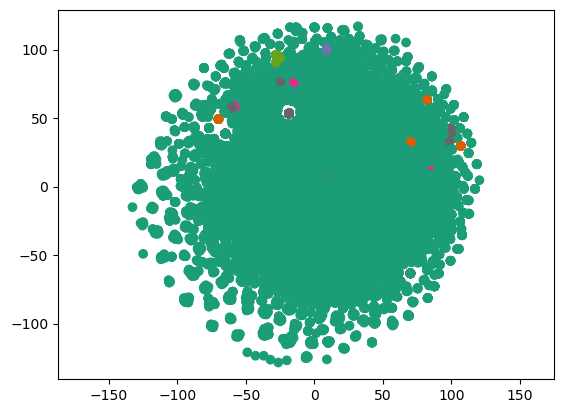

In [19]:
from sklearn.manifold import TSNE

embedding = TSNE().fit_transform(adjMat)
plt.scatter(embedding[:, 0], embedding[:, 1], c=sksc.labels_, cmap='Dark2')
plt.gca().set_aspect('equal', 'datalim')


In [20]:
uniqueNodes = set()
    

amztop5k = pd.read_csv('../../DataSets/SNAP/com-amazon.top5000.cmty.txt.gz', compression='gzip', comment='#', header=None)
amztop5k

,0
0,164985\t225214\t232761
1,105089\t282815\t331787
2,167906\t288975\t421279\t442612\t451312
3,69880\t231953\t518997\t523128
4,135499\t160294\t304770
...,...
4995,231176\t357878\t372935
4996,169423\t465191\t528417
4997,54847\t82457\t492247
4998,12785\t27959\t82924


In [26]:
communities = []
uniqueNodes = []

with gzip.open('../../DataSets/SNAP/com-amazon.top5000.cmty.txt.gz','rt') as amzfile:
    for l in amzfile.readlines():
        nodes = l.strip().split('\t')
        communities.append(nodes)
        uniqueNodes += nodes

uniqueNodes = set(uniqueNodes)
uniqueNodeToIndexMap = {n:i for i,n in enumerate(uniqueNodes)}
uniqueIndexToNodeMap = {i:n for i,n in enumerate(uniqueNodes)}

uniquenNodeCount=len(uniqueNodes)
community_5k_adjmat = np.zeros((uniquenNodeCount, uniquenNodeCount))

for cnt, c in enumerate(communities):
    cnt += 1
    print(cnt , end='\r')
    for i in range(len(c)):
        for j in range(i+1, len(c)):
            community_5k_adjmat[uniqueNodeToIndexMap[c[i]]][uniqueNodeToIndexMap[c[j]]] = 1
            community_5k_adjmat[uniqueNodeToIndexMap[c[j]]][uniqueNodeToIndexMap[c[i]]] = 1
        
    

In [30]:
sksc = sklearn.cluster.SpectralClustering(n_clusters=14, affinity='precomputed').fit(community_5k_adjmat)
Counter(sksc.labels_)

C:\Users\soura\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


NameError: name 'Counter' is not defined

In [31]:
from collections import Counter
Counter(sksc.labels_)

Counter({8: 11262,
         0: 2050,
         4: 921,
         7: 626,
         11: 344,
         13: 227,
         2: 214,
         3: 200,
         12: 191,
         9: 181,
         10: 178,
         5: 151,
         1: 107,
         6: 64})

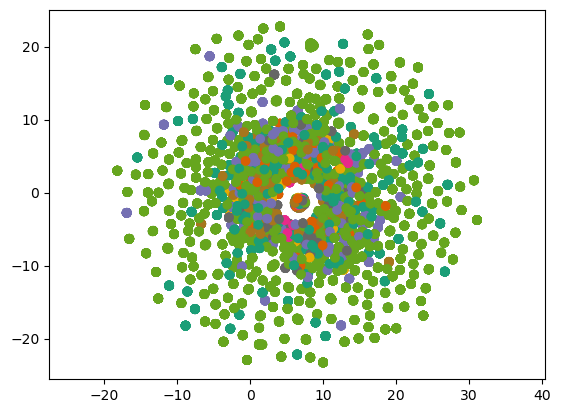

In [32]:
reducer = umap.UMAP()
#embedding = reducer.fit_transform(adjMat)
reducer.fit(community_5k_adjmat)
embedding = reducer.transform(community_5k_adjmat)

#plt.scatter(embedding[:, 0], embedding[:, 1], c=spec_astroPhy.labels_, cmap='Dark2')
plt.scatter(embedding[:, 0], embedding[:, 1], c=sksc.labels_, cmap='Dark2')
plt.gca().set_aspect('equal', 'datalim')


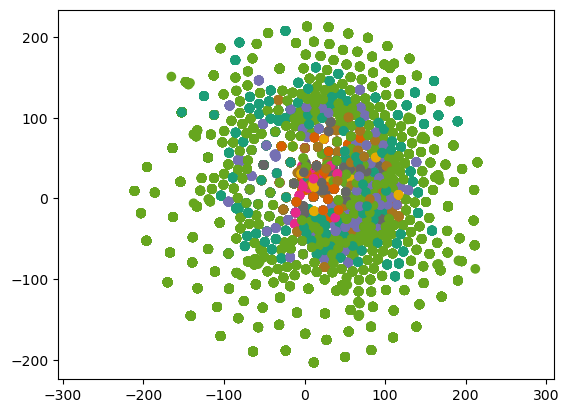

In [33]:
from sklearn.manifold import TSNE

embedding = TSNE().fit_transform(community_5k_adjmat)
plt.scatter(embedding[:, 0], embedding[:, 1], c=sksc.labels_, cmap='Dark2')
plt.gca().set_aspect('equal', 'datalim')


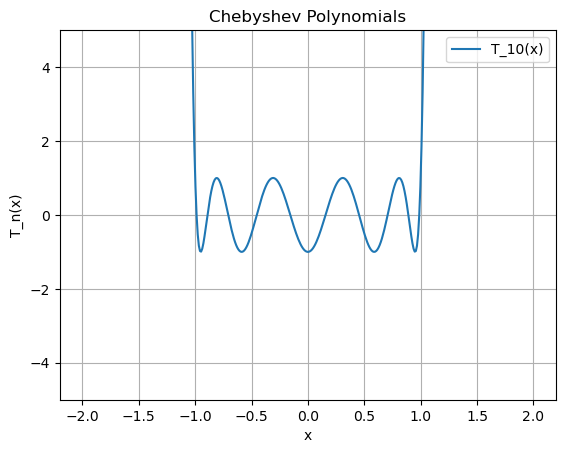

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import chebyt

x = np.linspace(-2, 2, 400)
fig, ax = plt.subplots()
ax.set_title('Chebyshev Polynomials')
ax.set_xlabel('x')
ax.set_ylabel('T_n(x)')

#for n in range(5,6,5):
#    ax.plot(x, chebyt(n)(x), label=f'T_{n}(x)')
n=10
ax.plot(x, chebyt(n)(x), label=f'T_{n}(x)')
ax.legend()
ax.grid(True)
ax.set_ylim(-5,5)
plt.show()